# Pro and Cons of the EM Algorithm for coin tosses 
The EM Algorithm does not always converge to the global maximum. It can get stuck in local maxima and it can even get stuck in saddle points (with at least one stable and one unstable fixed point, i.e. a gradient zero point). Proofs of EM convergence are only about non-decreasing likelihoods. But given enough data, it often converges to the sample size theoretic optimum, which is given by the MLE. EM will practically never converge to the ground truth of the parameters of the generative model, for small datasets. Yet, if there is enough variance / information in the data, then EM may give us the exact parameter estimates from MLE, or even the exact ground truth values. This jupyter code helps demonstrate those intricacies hands-on in practice.  

In [8]:
# Expectation Maximization, v3 (Jan Nagler, May 2021) for a coin tosses and data generator = throwing coin, experiment
# adapted/augmented based on K. Rosaen 
# Here simplified: ASSUMPTION each coin will be thrown with prob=1/2 (pA=pB=1/2, known)
# With Data generation unit and theoretical optimum, Jan Nagler
# What we dont know: theta_A, theta_B = prob. for heads for respective coin

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline

#EM algorithm
def coin_em(rolls,theta_A=None, theta_B=None, max_iter=50):
    
    # Initial Guess
    theta_A = theta_A or random.random() #take value or start wild between 0 and 1
    theta_B = theta_B or random.random()
    
    # theta vector
    thetas = [(theta_A, theta_B)]
    
    # Iterate
    for i in range(max_iter):
        print("#%d:\t%0.4f %0.4f" % (i, theta_A, theta_B)) #significant digits 
        #print(round(variable, 3))
        heads_A, tails_A, heads_B, tails_B = e_step( rolls, theta_A, theta_B )
        theta_A, theta_B = m_step( heads_A, tails_A, heads_B, tails_B )
        thetas.append((theta_A,theta_B))
    
    return thetas, (theta_A,theta_B) #thetas are conveniently needed for a unnecessary plot at the end

# Compute expected value for heads_A, tails_A, heads_B, tails_B over rolls given coin biases
def e_step( rolls, theta_A, theta_B ):
    
    heads_A, tails_A = 0,0
    heads_B, tails_B = 0,0
    
    for trial in rolls:
        likelihood_A = coin_likelihood( trial, theta_A )
        likelihood_B = coin_likelihood( trial, theta_B )
        p_A = likelihood_A / ( likelihood_A + likelihood_B )
        p_B = likelihood_B / ( likelihood_A + likelihood_B )
        heads_A += p_A * trial.count("H")
        tails_A += p_A * trial.count("T")
        heads_B += p_B * trial.count("H")
        tails_B += p_B * trial.count("T") 
        
    return heads_A, tails_A, heads_B, tails_B

# M step: Compute values for theta that maximize the likelihood of expected number of heads/tails
def m_step(heads_A, tails_A, heads_B, tails_B):
    
    theta_A = np.divide( heads_A, heads_A + tails_A ) #np.divide avoids divby0s
    theta_B = np.divide( heads_B, heads_B + tails_B )
    
    return theta_A, theta_B

# p(X | Z, theta)
def coin_likelihood(roll, bias):
    numHeads = roll.count("H")
    flips = len(roll)
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads)

In [9]:
# plot EM convergence
def plot_coin_likelihood(rolls, thetas=None):
    # grid
    xvals = np.linspace(0.01,0.99,100)
    yvals = np.linspace(0.01,0.99,100)
    X,Y = np.meshgrid(xvals, yvals)
    
    # compute likelihood
    Z = []
    for i,r in enumerate(X):
        z = []
        for j,c in enumerate(r):
            z.append(coin_marginal_likelihood(rolls,c,Y[i][j]))
        Z.append(z)
    
    # plot
    plt.figure(figsize=(10,8))
    C = plt.contour(X,Y,Z,150)
    cbar = plt.colorbar(C)
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_A,\theta_B)$", fontsize=20)
    plt.xlabel(r"$\theta_A$", fontsize=20)
    plt.ylabel(r"$\theta_B$", fontsize=20)
    
    # plot thetas
    if thetas is not None:
        thetas = np.array(thetas)
        plt.plot(thetas[:,0], thetas[:,1], '-k', lw=2.0)
        plt.plot(thetas[:,0], thetas[:,1], 'ok', ms=5.0)
        
# log P(X | theta), only used for plot
def coin_marginal_likelihood( rolls, biasA, biasB ):
    trials = []
    for roll in rolls:
        h = roll.count("H")
        t = roll.count("T")
        likelihoodA = coin_likelihood(roll, biasA)
        likelihoodB = coin_likelihood(roll, biasB)
        trials.append(np.log(0.5 * (likelihoodA + likelihoodB)))
    return sum(trials)

In [16]:
# Generate surrogate data
import random

# Number of experiments
experiments = 10 #the smaller this number to worst the performance/estimate

# Number of coin tosses for each trial
coin_tosses = 10 #the smaller this number to worst the performance/estimate

# Experiment ground truth properties: Prob to choose coin A for the trial
pA = 0.5
pB = 1-pA
# Coin ground truth properties: Prob for heads and tails
p_heads_A = 0.8
p_heads_B = 0.4

# empty array where all tosses are stored
rolls= []

A_heads = 0
B_heads = 0
A_tails = 0
B_tails = 0

for i in range(0,experiments):
    trial = ""
    A=0
    # Choose coin: p fixed for single trial
    if ( random.uniform(0, 1) < pA ): 
        p = p_heads_A
        A=1
    else:
        p = p_heads_B
        A=0
        
    for j in range(0,coin_tosses):
        # generate outcome
        outcome = random.uniform(0, 1)
        if (outcome < p): 
            trial += "H"
            if (A==1): 
                A_heads += 1
            else:
                B_heads += 1
        else: 
            trial += "T"
            if (A==1): 
                A_tails += 1
            else:
                B_tails += 1
    rolls.append( trial ) 
    
#print entire outcomes of experiment     
print(rolls)

# Call EM
thetas , _  = coin_em( rolls, 0.8, 0.4, max_iter=15 )

print("Chosen ground truth (which is sample-independent!): ")
print("%0.6f %0.6f" % (p_heads_A, p_heads_B))
# In fact, here, we do not need EM since we can compute MLE directly. So MLE serves as validation.
print("MLE estimates from data (finite sample size estimates are the theoretical optimum!):")
MLE_pA, MLE_pB = m_step( A_heads, A_tails, B_heads, B_tails )
print("%0.6f %0.6f" % (MLE_pA, MLE_pB))
#print(round(MLE_pA,3), round(MLE_pB,3))

['HHHHHHTHTH', 'HHHHHHHHHH', 'HHHHHHHHTT', 'HHHHHHTTHH', 'HTHHHHTTHT', 'THTTTTHHHH', 'THHHHHHHTH', 'HHHHHHHHTH', 'TTTHHTTHHT', 'HTHTHTHHHH']
#0:	0.8000 0.4000
#1:	0.8117 0.5133
#2:	0.8240 0.5691
#3:	0.8298 0.5968
#4:	0.8321 0.6095
#5:	0.8329 0.6151
#6:	0.8331 0.6175
#7:	0.8331 0.6185
#8:	0.8331 0.6189
#9:	0.8331 0.6191
#10:	0.8331 0.6192
#11:	0.8331 0.6192
#12:	0.8331 0.6192
#13:	0.8331 0.6192
#14:	0.8331 0.6192
Chosen ground truth (which is sample-independent!): 
0.800000 0.400000
MLE estimates from data (finite sample size estimates are the theoretical optimum!):
0.800000 0.450000


How EM got there...


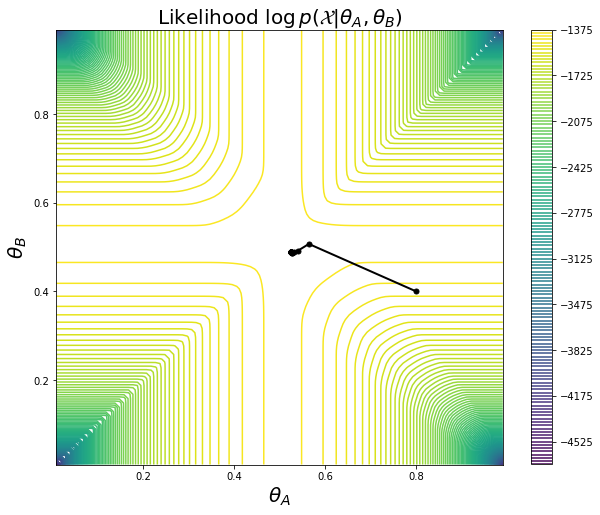

In [13]:
print("How EM got there...")
plot_coin_likelihood(rolls, thetas)